In [1]:
from SimPEG import Mesh, Utils, EM, Maps
from pymatsolver import Pardiso
from scipy.constants import mu_0
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pyMKL import mkl_set_num_threads
from multiprocessing import Pool
from SimPEG import Mesh
from simpegskytem import (
    ProblemSkyTEM, GlobalAEMSurveyTD, 
    GlobalSkyTEM, get_skytem_survey
)

In [2]:
data_dir = "/Users/sgkang/Dropbox/Stanford/Resolution/aarhusinv/em1dinv_examples/notebooks/"

In [3]:
# generate mesh
hx = np.ones(200) * 50
hy = np.ones(40) * 250
hz = np.ones(100) * 5
mesh_global = Mesh.TensorMesh([hx, hy, hz], x0=[-hx.sum()/2., -hy.sum()/2., -hz.sum() + 50.])

# generate survey
x_inds = np.argwhere(np.logical_and(mesh_global.vectorCCx > -4000, mesh_global.vectorCCx < 4000))[::20]
y_inds = np.argwhere(np.logical_and(mesh_global.vectorCCy > -4000, mesh_global.vectorCCy < 4000))[::20]
x = mesh_global.vectorCCx[x_inds]
y = mesh_global.vectorCCy[y_inds]
src_locations = Utils.ndgrid(x, y, np.r_[30.])
rx_locations = Utils.ndgrid(x+13.25, y, np.r_[30.+2.])
topo = Utils.ndgrid(x, y, np.r_[0.])
source_area = 536.36
waveform_hm = np.loadtxt(data_dir+"HM_butte_304.txt")
time_gates_hm = np.loadtxt(data_dir+"HM_butte_304_gates")[7:,:] * 1e-6
waveform_lm = np.loadtxt(data_dir+"LM_butte_304.txt")
time_gates_lm = np.loadtxt(data_dir+"LM_butte_304_gates")[8:,:] * 1e-6

time_input_currents_HM = waveform_hm[:,0]
input_currents_HM = waveform_hm[:,1]
time_input_currents_LM = waveform_lm[:,0]
input_currents_LM = waveform_lm[:,1]
    
time_LM = time_gates_lm[:,3] - waveform_lm[:,0].max()
time_HM = time_gates_hm[:,3] - waveform_hm[:,0].max()
n_sounding = src_locations.shape[0]

In [74]:
actv = mesh_global.gridCC[:,2] < 0.
sigma = np.ones(mesh_global.nC) * 1e-8
sigma_background = 1./20.
sigma_target = 1./5.
thickness = np.array([50, 10], dtype=float)
depth = -np.cumsum(thickness)
inds = np.logical_and(mesh_global.gridCC[:,2]<depth[0], mesh_global.gridCC[:,2]>depth[1])
sigma[actv] = sigma_background
sigma[inds] = sigma_target
sigma[(mesh_global.gridCC[:,0]<0.) & actv] = sigma_background

(<matplotlib.collections.QuadMesh at 0x1a24921278>,)

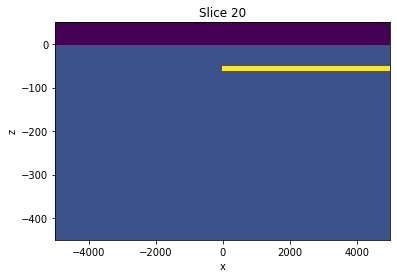

In [75]:
mesh_global.plotSlice(sigma, normal='Y')

In [76]:
def get_skytem_survey(
    topo,
    src_locations,
    rx_locations,
    time,
    time_input_currents,
    input_currents,
    base_frequency=25,
    src_type="VMD",
    rx_type="dBzdt",    
    moment_type="dual",        
    time_dual_moment=None,
    time_input_currents_dual_moment=None,
    input_currents_dual_moment=None,
    base_frequency_dual_moment=210,
    wave_type="general",    
    field_type="secondary",
    
):
    
    n_sounding = src_locations.shape[0]    
    time_list = [time for i in range(n_sounding)]
    time_dual_moment_list = [time_dual_moment for i in range(n_sounding)]
    src_type_array = np.array([src_type], dtype=str).repeat(n_sounding)
    rx_type_array = np.array([rx_type], dtype=str).repeat(n_sounding)
    wave_type_array = np.array([wave_type], dtype=str).repeat(n_sounding)    
    field_type_array = np.array([field_type], dtype=str).repeat(n_sounding)  
    input_currents_list=[input_currents_HM for i in range(n_sounding)]
    time_input_currents_list=[time_input_currents_HM for i in range(n_sounding)]
    base_frequency_array = np.array([base_frequency]).repeat(n_sounding)
    input_currents_dual_moment_list =[input_currents_LM for i in range(n_sounding)]
    time_input_currents_dual_moment_list =[time_input_currents_LM for i in range(n_sounding)]
    base_frequency_dual_moment_list = np.array([base_frequency_dual_moment]).repeat(n_sounding)
    moment_type_array = np.array([moment_type], dtype=str).repeat(n_sounding)    
    
    survey = GlobalAEMSurveyTD(
        topo = topo,
        src_locations = src_locations,
        rx_locations = rx_locations,
        src_type = src_type_array,
        rx_type = rx_type_array,
        field_type = field_type,
        time = time_list,
        wave_type = wave_type_array,
        moment_type = moment_type_array,
        time_input_currents = time_input_currents_list,
        input_currents = input_currents_list,
        base_frequency = base_frequency_array,
        time_dual_moment = time_dual_moment_list,
        time_input_currents_dual_moment = time_input_currents_dual_moment_list,
        input_currents_dual_moment = input_currents_dual_moment_list,
        base_frequency_dual_moment = base_frequency_dual_moment_list,
    )    
    
    return survey

In [77]:
from SimPEG import Maps

In [78]:
survey = get_skytem_survey(
    topo,
    src_locations,
    rx_locations,
    time_HM,
    time_input_currents_HM,
    input_currents_HM,
    25.,
    src_type="VMD",
    rx_type="dBzdt",    
    moment_type="dual",        
    time_dual_moment=time_LM,
    time_input_currents_dual_moment=time_input_currents_LM,
    input_currents_dual_moment=input_currents_LM,
    base_frequency_dual_moment=210.,
    wave_type="general",    
    field_type="secondary",    
)

simulation = GlobalSkyTEM(mesh_global, sigma=sigma, actv=actv)
simulation.pair(survey)

>> Set parameters


In [79]:
# write inputs to the disk
simulation.write_inputs_on_disk_pool()

In [80]:
# run 
data = simulation.forward(sigma)

In [81]:
simulation.clean_work_dir()

In [82]:
DATA = data.reshape((time_HM.size + time_LM.size, survey.n_sounding), order='F')

In [83]:
from simpegEM1D import EM1D, EM1DSurveyTD, Utils1D, get_vertical_discretization_time, set_mesh_1d, piecewise_pulse
from SimPEG import Maps
def simulation(src_type, n_pulse=1, use_lowpass_filter=False):
    hz = np.r_[thickness.copy(), 1e3]
    mesh1D = set_mesh_1d(hz)
    depth = -mesh1D.gridN[:-1]

    if src_type == "CircularLoop":
        # Effective radius
        radius = np.sqrt(source_area/np.pi)        
        TDsurvey = EM1DSurveyTD(
            rx_location = np.array([0., 0., 100.+30.]),
            src_location = np.array([0., 0., 100.+30.]),
            topo = np.r_[0., 0., 100.],
            depth = depth,
            rx_type = 'dBzdt',
            wave_type = 'general',
            src_type = 'CircularLoop',    
            I = 1,    
            a = radius,
            time = time_HM,
            time_input_currents=time_input_currents_HM,
            input_currents=input_currents_HM,
            n_pulse = n_pulse,
            base_frequency = 25.,
            use_lowpass_filter=use_lowpass_filter,
            high_cut_frequency=210*1e3,
            moment_type='dual',
            time_dual_moment = time_LM,    
            time_input_currents_dual_moment=time_input_currents_LM,
            input_currents_dual_moment=input_currents_LM,
            base_frequency_dual_moment=210,    
        )
    elif src_type == "VMD":
        TDsurvey = EM1DSurveyTD(
            rx_location = np.array([0., 0., 100.+30.+2.]),
            src_location = np.array([0., 0., 100.+30.]),
            topo = np.r_[0., 0., 100.],
            depth = depth,
            rx_type = 'dBzdt',
            wave_type = 'general',
            src_type = 'VMD',    
            offset=np.array([13.25]),
            I = 1.,
            time = time_HM,
            time_input_currents=time_input_currents_HM,
            input_currents=input_currents_HM,
            n_pulse = n_pulse,
            base_frequency = 25.,
            use_lowpass_filter=use_lowpass_filter,
            high_cut_frequency=210*1e3,
            moment_type='dual',
            time_dual_moment = time_LM,    
            time_input_currents_dual_moment=time_input_currents_LM,
            input_currents_dual_moment=input_currents_LM,
            base_frequency_dual_moment=210,    
        )
    chi_half = 0.
    expmap = Maps.ExpMap(mesh1D)
    prob = EM1D(mesh1D, sigmaMap=expmap, verbose=False)
    m_true = np.log(1./resistivity)
    if prob.ispaired:
        prob.unpair()
    if TDsurvey.ispaired:
        TDsurvey.unpair()
    prob.pair(TDsurvey)
    prob.chi = np.zeros(TDsurvey.n_layer)
    d_true = -TDsurvey.dpred(m_true)
    return d_true

In [84]:
resistivity_background = 1./sigma_background
resistivity_target = 1./sigma_target
resistivity = np.array([resistivity_background, resistivity_target, resistivity_background], dtype=float)
source_area = 536.36

In [85]:
temp = simulation('VMD')

In [86]:
from ipywidgets import interact, IntSlider

In [87]:
def foo (i_sounding):
    data_hm = DATA[:time_HM.size,i_sounding]
    data_lm = DATA[time_HM.size:,i_sounding]

    plt.loglog(time_HM, temp[:time_HM.size], 'k')
    plt.loglog(time_LM, temp[time_HM.size:], 'r')
    plt.loglog(time_HM, -data_hm, 'k.')
    plt.loglog(time_LM, -data_lm, 'r.')

In [88]:
interact(foo, i_sounding=IntSlider(min=0, max=survey.n_sounding-1, value=0))

interactive(children=(IntSlider(value=0, description='i_sounding', max=15), Output()), _dom_classes=('widget-i…

<function __main__.foo(i_sounding)>